# Assignment 2

# Part 2: Classic recognition

Questions 2–7 are coding questions. You will implement different image representations and train linear classifiers with them. You will start with more flexible image representations and progressively move onto more rigid representations. Questions 8-10 are written questions to be answered in the PDF. You will report and reflect on the results, analyze the pros/cons of each representation and discuss possible improvements. 

In [21]:
%load_ext autoreload
%autoreload 2
### ↑ add these two lines so the updates in .py files are reflected 
###   to the notebook without needing to restart the kernel

import os, pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt

from utils import get_CIFAR10_data, train, evaluate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

#### We provide you with a linear (softmax) classifier, as well as code to load the CIFAR-10 dataset.

The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. See the dataset website for more details: https://www.cs.toronto.edu/~kriz/cifar.html.

**Do this:** Download the dataset from this link (https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz), place it where you want, and unzip it. Then try running the below code to see if you can load the dataset. Change `cifar10_dir` to your data path.

In [2]:
meta = pickle.load(open('data/cifar-10-batches-py/batches.meta', 'rb'), encoding='bytes')
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


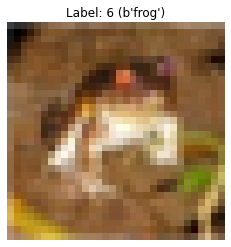

In [21]:
# Visualize a sample image
i = 0
label = y_train[i]
class_name = meta[b'label_names'][label]
plt.imshow(np.uint8(X_train[i])); plt.axis('off')
plt.title('Label: {} ({})'.format(label, class_name)); plt.show()

## Question 2. Color features (5 points)

First, we are going to explore using average color features to train a classifier. For each RGB color channel, average the pixel intensities. So a 32x32x3 image will be represented in a 1x3 vector.

**Do this:** Implement the `load_average_color_with_bias()` in `assn2.py` that computes average color features. Then train a classifier. Tune the regularization strength to train a good classifier.

In [3]:
# Freshly load the data
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [4]:
from assn2 import load_average_color_with_bias
X_train = load_average_color_with_bias(X_train)
X_val = load_average_color_with_bias(X_val)
X_test = load_average_color_with_bias(X_test)

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (4500, 4)
Train labels shape:  (4500,)
Validation data shape:  (500, 4)
Validation labels shape:  (500,)
Test data shape:  (1000, 4)
Test labels shape:  (1000,)


In [5]:
# TODO : Define regularization strengths. Put multiple values, more than 5,
#        See which regularization strength gives the best validation accuracy. 
regularization_strengths = [0.001,0.005,0.01,0.05,0.1,0.5,1]

# Train a classifier
best_color = train(X_train, y_train, X_val, y_val, X_test, y_test, regularization_strengths)


reg 1.000000e-03 train accuracy: 0.130444 val accuracy: 0.148000
reg 5.000000e-03 train accuracy: 0.130889 val accuracy: 0.144000
reg 1.000000e-02 train accuracy: 0.139778 val accuracy: 0.152000
reg 5.000000e-02 train accuracy: 0.134222 val accuracy: 0.140000
reg 1.000000e-01 train accuracy: 0.135111 val accuracy: 0.160000
reg 5.000000e-01 train accuracy: 0.148222 val accuracy: 0.148000
reg 1.000000e+00 train accuracy: 0.120222 val accuracy: 0.124000

best validation accuracy achieved during training: 0.160000

final test set accuracy: 0.139000


In [ ]:
# ALL OPERATIONS
from assn2 import load_average_color_with_bias
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)
X_train = load_average_color_with_bias(X_train)
X_val = load_average_color_with_bias(X_val)
X_test = load_average_color_with_bias(X_test)
regularization_strength = 0.1
best_color = train(X_train, y_train, X_val, y_val, X_test, y_test, regularization_strength)

## Question 3. Bag of SIFT features (15 points)

Bag of words models are a popular technique for image classification inspired by models used in natural language processing. The model ignores or downplays word arrangement (spatial information in the image) and classifies based on a histogram of the frequency of visual words. The visual word "vocabulary" is established by clustering a large corpus of local features. In this question, you will extract SIFT features from the training images. These result in a Nx128 dimensional matrix where N is the number of keypoints. After extracting SIFT features from all training images, we can use the K-means clustering algorithm to cluster these features into K clusters each represented by a 128-dimensional centroid. Now we have a bag of visual words (clusters) and can represent each image as a histogram of SIFT features assigned to these clusters. Specifically, each image will be represented as a K-dimensional histogram. Using these representations, you can train a classifier as before.

**Do this**: Extract SIFT features. Do K-means clustering of the training images' SIFT features. Construct a histogram representation of the images and train a classifier. Specifically, implement `extract_sift()` in `features.py` and `load_flatten()` in `assn2.py`.

#### Example for extracting SIFT features

Check out OpenCV's tutorial on extracting SIFT features: https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html.

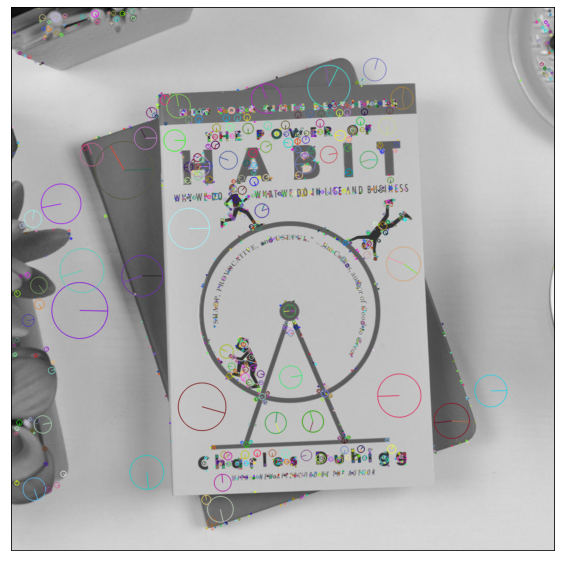

In [6]:
# Read in the image
img = cv2.imread('imgs/table.jpeg')

# Convert to greyscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Create a SIFT feature extractor
sift = cv2.SIFT_create() # or cv2.xfeatures2d.SIFT_create()

# Detect features from the image
keypoints, descriptors = sift.detectAndCompute(gray, None)

# Draw and visualize the detected keypoints on the image
sift_image = cv2.drawKeypoints(gray, keypoints, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(10, 10))
plt.imshow(sift_image)
plt.xticks([]), plt.yticks([])
plt.show()

#### Your work starts here

In [7]:
# Freshly load the data
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [8]:
# TODO: Write a function extract sift featuress
from features import extract_sift_for_dataset
from assn2 import load_flatten

In [9]:
# TODO: Define step_size (sampling density) for sampling keypoints in a grid.
step_size = 4

# Extract dense SIFT features.
X_train_features = extract_sift_for_dataset(X_train, step_size=step_size)
#keypointの箇所の使い方がわからない！
X_val_features = extract_sift_for_dataset(X_val, step_size=step_size)
X_test_features = extract_sift_for_dataset(X_test, step_size=step_size)

# Flatten to [imagenumber x keypoint number per image, descriptor size]
X_train_features_flattened = load_flatten(X_train_features)

In [22]:
# the extracted SIFT features and build a visual vocabulary.
# This will take time even with well optimized code! Try to balance K, niter if it is too slow. 
from kmeans import kmeans


In [12]:

K = 16
niter = 4
labels_train, centroids = kmeans(X_train_features_flattened, K, niter)

0
centnum 0
centnum 1
centnum 2
centnum 3
centnum 4
centnum 5
centnum 6
centnum 7
centnum 8
centnum 9
centnum 10
centnum 11
centnum 12
centnum 13
centnum 14
centnum 15
1
centnum 0
centnum 1
centnum 2
centnum 3
centnum 4
centnum 5
centnum 6
centnum 7
centnum 8
centnum 9
centnum 10
centnum 11
centnum 12
centnum 13
centnum 14
centnum 15
2
centnum 0
centnum 1
centnum 2
centnum 3
centnum 4
centnum 5
centnum 6
centnum 7
centnum 8
centnum 9
centnum 10
centnum 11
centnum 12
centnum 13
centnum 14
centnum 15
3
centnum 0
centnum 1
centnum 2
centnum 3
centnum 4
centnum 5
centnum 6
centnum 7
centnum 8
centnum 9
centnum 10
centnum 11
centnum 12
centnum 13
centnum 14
centnum 15


In [13]:
from assn2 import load_histogram_with_bias
# TODO: Form histograms for each of images
train_hist = load_histogram_with_bias(X_train_features, centroids)
val_hist = load_histogram_with_bias(X_val_features, centroids)
test_hist = load_histogram_with_bias(X_test_features, centroids)

print('Train data shape: ', val_hist.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', val_hist.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', test_hist.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (500, 17)
Train labels shape:  (4500,)
Validation data shape:  (500, 17)
Validation labels shape:  (500,)
Test data shape:  (1000, 17)
Test labels shape:  (1000,)


In [15]:
# TODO : Define regularization strengths. Put multiple values, more than 5,
#        See which regularization strength gives the best validation accuracy. 
#
#
#        Also change step_size, K, niter above, find the best parameter with the best validation accuracy.
regularization_strengths = [1e3,3e3,5e3,7e3,1e4,3e4]

# Train a classifier
best_color = train(train_hist, y_train, val_hist, y_val, test_hist, y_test, regularization_strengths, skip_test=True)

reg 1.000000e+03 train accuracy: 0.237556 val accuracy: 0.246000
reg 3.000000e+03 train accuracy: 0.232000 val accuracy: 0.242000
reg 5.000000e+03 train accuracy: 0.220444 val accuracy: 0.220000
reg 7.000000e+03 train accuracy: 0.194222 val accuracy: 0.202000
reg 1.000000e+04 train accuracy: 0.221778 val accuracy: 0.220000
reg 3.000000e+04 train accuracy: 0.218444 val accuracy: 0.186000

best validation accuracy achieved during training: 0.246000


In [16]:
# Now with the best parameter you found, get the test accuracy. 
evaluate(best_color, test_hist, y_test)

final test set accuracy: 0.232000


## Question 4. SPM representation (15 points)

Above, we selected feature points in uniform-distanced pixels.
One drawback of the bag-of-words approach is that it discards spatial information. 

Hence, we will now try encoding spatial information using Spatial Pyramid Matching (SPM) proposed in Lazebnik et al. 2006. At a high level, SPM works by breaking up an image into different regions and computing the SIFT descriptor at each region, forming a histogram of visual words in each region, and then concatenatating them into a single 1D vector representation.

**Do this**: Construct a SPM representation of the images and train a classifier. Specifically, implement `spatial_pyramid_matching_with_bias()` in `features.py`.

In [17]:
# Freshly load the data
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [18]:
# TODO: Define parameters {L, K, niter}
L = 2 # Number of levels in SPM


# Extract SIFT features on every pixel
X_train_features = extract_sift_for_dataset(X_train, step_size=1)
print("done a")
X_train_features_flattened = load_flatten(X_train_features)
print("done b")

X_val_features = extract_sift_for_dataset(X_val, step_size=1)
print("done c")

X_test_features = extract_sift_for_dataset(X_test, step_size=1)
print("done d")



done a
done b
done c
done d


In [23]:
import importlib
importlib.reload('kmeans')

In [27]:

# \Use your kmeans implementation from part 1 
# to cluster the extracted SIFT features and build a visual vocabulary
K = 16
niter = 4
# from kmeans import kmeans
_, centroids = kmeans(X_train_features_flattened, K, niter)

aa
a
b
c
0
process 0
process 1
process 2
process 3
process 4
process 5
process 6
process 7
process 8
process 9
process 10
process 11
process 12
process 13
process 14
process 15
1
process 0
process 1
process 2
process 3
process 4
process 5
process 6
process 7
process 8
process 9
process 10
process 11
process 12
process 13
process 14
process 15
2
process 0
process 1
process 2
process 3
process 4
process 5
process 6
process 7
process 8
process 9
process 10
process 11
process 12
process 13
process 14
process 15
3
process 0
process 1
process 2
process 3
process 4
process 5
process 6
process 7
process 8
process 9
process 10
process 11
process 12
process 13
process 14
process 15


In [30]:
np.savetxt('q4centroids.txt',centroids)

In [32]:
np.shape(np.loadtxt('q4centroids.txt'))

(16, 128)

In [33]:
# TODO: Write code to do SPM
from features import spatial_pyramid_matching_with_bias

In [47]:
# Note: This may take some time to run, around 1 minute.
X_train_spm = [spatial_pyramid_matching_with_bias(L, 
                                        X_train_features[i].reshape((32, 32, 128)), 
                                        centroids) 
               for i in range(len(X_train))]
print("a")

X_val_spm = [spatial_pyramid_matching_with_bias(L,
                                      X_val_features[i].reshape((32, 32, 128)), 
                                      centroids) 
             for i in range(len(X_val))]
print("b")

X_test_spm = [spatial_pyramid_matching_with_bias(L,
                                       X_test_features[i].reshape((32, 32, 128)),
                                       centroids)  
              for i in range(len(X_test))]
print("c")

X_train_spm = np.stack(X_train_spm, 0)
X_val_spm = np.stack(X_val_spm, 0)
X_test_spm = np.stack(X_test_spm, 0)

print('Train data shape: ', X_train_spm.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val_spm.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test_spm.shape)
print('Test labels shape: ', y_test.shape)

a
b
c
Train data shape:  (4500, 337)
Train labels shape:  (4500,)
Validation data shape:  (500, 337)
Validation labels shape:  (500,)
Test data shape:  (1000, 337)
Test labels shape:  (1000,)


In [48]:
# TODO : Define regularization strengths. Put multiple values, more than 5,
#        See which regularization strength gives the best validation accuracy. 
#
#
#        Also change L, K, niter above, find the best parameter with the best validation accuracy.

regularization_strengths = [1e3,3e3,5e3,7e3,1e4,3e4]

# Train a classifier
best_color = train(X_train_spm, y_train, X_val_spm, y_val, X_test_spm, y_test, regularization_strengths, skip_test=True)

reg 1.000000e+03 train accuracy: 0.285556 val accuracy: 0.272000
reg 3.000000e+03 train accuracy: 0.278444 val accuracy: 0.266000
reg 5.000000e+03 train accuracy: 0.261111 val accuracy: 0.272000
reg 7.000000e+03 train accuracy: 0.250222 val accuracy: 0.242000
reg 1.000000e+04 train accuracy: 0.256889 val accuracy: 0.264000
reg 3.000000e+04 train accuracy: 0.219778 val accuracy: 0.222000

best validation accuracy achieved during training: 0.272000


In [49]:
# Now with the best parameter you found, get the test accuracy. 
evaluate(best_color, X_test_spm, y_test)

final test set accuracy: 0.273000


## Question 5. Histogram of Oriented Gradients (10 points)

Rather than extracting local SIFT features, we can compute a global histogram of oriented gradients (HOG) image descriptor. 

**Do this**: Implement `get_differential_filter()` and `filter_image()` in `features.py`, and `load_hog_representation_with_bias()` in `assn2.py`. Then compute HOG descriptors and train a classifier. 

In [50]:
# Freshly load the data
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [51]:
# TODO: Implement get_differential_filter() and filter_image()
# Note: extract_hog() will make use of these two functions.
from features import extract_hog

In [52]:
# TODO: Define parameters
cell_size = 2 # Start with 2 or 4, but feel free to try other parameters
block_size = 2 # Start with 2, but feel free to try other parameters

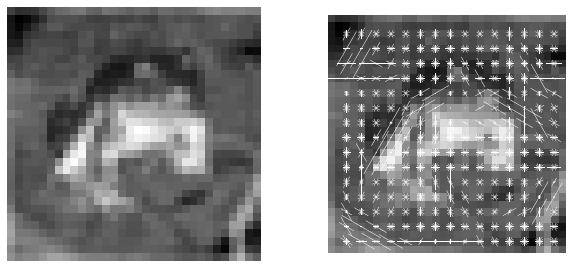

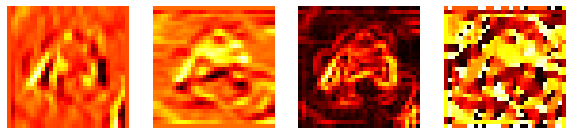

In [53]:
# Try running your code on a single image
img = X_train[0]
img = cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2GRAY)
hog = extract_hog(img, cell_size=cell_size, block_size=block_size, plot=True)

In [61]:
img = X_train[0]
img = cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2GRAY)
hog = extract_hog(img, cell_size=cell_size, block_size=block_size, plot=False)

In [70]:
len(hog)

5400

In [62]:
X_hog = []

In [63]:
X_hog.append(hog)

In [66]:
np.shape(X_hog)

(1, 5400)

In [67]:
X_hog.append(hog)
np.shape(X_hog)


(2, 5400)

In [71]:
from assn2 import load_hog_representation_with_bias
# TODO: Build HOG representations. This can take up to 2 minutes. 
X_train_hog =  load_hog_representation_with_bias(X_train, cell_size, block_size)
print("a")
X_val_hog = load_hog_representation_with_bias(X_val, cell_size, block_size)
print("b")

X_test_hog = load_hog_representation_with_bias(X_test, cell_size, block_size)
print("c")


print('Train data shape: ', X_train_hog.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val_hog.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test_hog.shape)
print('Test labels shape: ', y_test.shape)

a
b
c
Train data shape:  (4500, 5401)
Train labels shape:  (4500,)
Validation data shape:  (500, 5401)
Validation labels shape:  (500,)
Test data shape:  (1000, 5401)
Test labels shape:  (1000,)


In [72]:
# TODO : Define regularization strengths. Put multiple values, more than 5,
#        See which regularization strength gives the best validation accuracy.
regularization_strengths = [1e3,3e3,5e3,7e3,1e4,3e4]

# Train a classifier
best_color = train(X_train_hog, y_train, X_val_hog, y_val, X_test_hog, y_test, regularization_strengths)

reg 1.000000e+03 train accuracy: 0.124667 val accuracy: 0.112000
reg 3.000000e+03 train accuracy: 0.105556 val accuracy: 0.088000
reg 5.000000e+03 train accuracy: 0.108222 val accuracy: 0.088000
reg 7.000000e+03 train accuracy: 0.105778 val accuracy: 0.090000
reg 1.000000e+04 train accuracy: 0.189111 val accuracy: 0.134000
reg 3.000000e+04 train accuracy: 0.101333 val accuracy: 0.128000

best validation accuracy achieved during training: 0.134000

final test set accuracy: 0.137000


## Question 6. Pixels (5 points)

Finally, let's use the pixels themselves to train a classifier. That is, just reshape a 32x32x3 image into a 32x32x3=3072 vector.

**Do this:** Process the images and train a classifier. Specifically, implement `load_vector_image_with_bias()` in `assn2.py`.

In [73]:
# Freshly load the data
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [75]:
from assn2 import load_vector_image_with_bias
X_train, X_val, X_test = load_vector_image_with_bias(X_train, X_val, X_test)

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (4500, 3073)
Train labels shape:  (4500,)
Validation data shape:  (500, 3073)
Validation labels shape:  (500,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)


In [76]:
# TODO : Define regularization strengths. Put multiple values, more than 5,
#        See which regularization strength gives the best validation accuracy. 
regularization_strengths = [1e3,3e3,5e3,7e3,1e4,3e4]
# Train a classifier
best_color = train(X_train, y_train, X_val, y_val, X_test, y_test, regularization_strengths)

reg 1.000000e+03 train accuracy: 0.293556 val accuracy: 0.286000
reg 3.000000e+03 train accuracy: 0.199778 val accuracy: 0.158000
reg 5.000000e+03 train accuracy: 0.142444 val accuracy: 0.136000
reg 7.000000e+03 train accuracy: 0.099556 val accuracy: 0.104000
reg 1.000000e+04 train accuracy: 0.118222 val accuracy: 0.108000
reg 3.000000e+04 train accuracy: 0.099111 val accuracy: 0.114000

best validation accuracy achieved during training: 0.286000

final test set accuracy: 0.276000


## Question 7. Results (10 points)

**Do this**: 

7-a. Create a table of the five models' achieved accuracy, best hyperparameter, and runtime. (6 points)

7-b. Briefly describe your results in a few sentences. Feel free to share your experience and highlight any interesting observations (e.g., you had to do more hyperparameter tuning for some than others). (4 points)

## Question 8. Analysis (10 points)

**Do this**: Create a confusion matrix for each of the five models. Feel free to use existing implementations such as [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) but make sure to interpret some subset of the results and demonstrate that you understand what the values in the confusion matrices mean. Do the confusion matrices reveal any interesting insights (e.g., truck is always misclassified as automobile)? For each of the 10 classes, which model works best? Describe any hypotheses you have on the results. One or two paragraphs would be sufficient.

Note: See `evaluate` in `utils.py` to learn how to use the trained model to get predictions. 

## Question 9. Improvement (9 points)

**Do this**: Identify one shortcoming of one or few of the systems you've worked with. Name an improvement you can implement to improve the system(s). You don't have to actually implement your proposed improvement, but describe exactly how you could go about implementing it and what pitfalls you might anticipate. What would be the pros and cons of this intervention? One or two paragraphs would be sufficient.

## Question 10. What to Use (6 points)

So far we explored how different features work for 10-way image classification.

**Do this**: 

9-a. For the task of **object detection**, which features do you think would work best? Describe your reasons in a few senteces. (2 points)

In [ ]:
img = cv2.imread('imgs/objectdetection.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(10, 10)); plt.title('Object detection')
plt.imshow(img); plt.axis('off'); plt.show()

9-b. For the task of **face detection**, which features do you think would work best? Describe your reasons in a few senteces. (2 points)

In [ ]:
img = cv2.imread('imgs/facedetection.png')
plt.figure(figsize=(10, 10)); plt.title('Face detection')
plt.imshow(img); plt.axis('off'); plt.show()

9-c. For the task of **scene classification**, which features do you think would work best? Describe your reasons in a few senteces. (2 points)

In [ ]:
img = cv2.imread('imgs/sceneclassification.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(10, 10)); plt.title('Scene classification')
plt.imshow(img); plt.axis('off'); plt.show()